In [1]:
from skddp_se.utils.config import Config, set_seed
import yaml
import torch
from skddp_se.model.simple_unet import SimpleTwinUnet
from skddp_se.model.loss import skddpLoss
import numpy as np
import json
from logging import getLogger
from logging import config as log_config
import torchaudio
import einops
import copy
import random
from pathlib import Path
from matplotlib import pyplot as plt
from IPython.display import Audio
from IPython.display import display

device_id = 0 

with open('./skddp_se/utils/logging.json', 'r') as f:
    log_conf = json.load(f)
log_config.dictConfig(log_conf)

speech_folder = Path("./corpus/LJSpeech-1.1/wavs/")
noise_folder = Path("./corpus/DEMAND/")

In [2]:
config_yaml = yaml.load(open("./configs/proposed.yaml", "r"), Loader=yaml.FullLoader)
config = Config(**copy.deepcopy(config_yaml))
set_seed(config.seed)
logger = getLogger(__name__)
DEVICE = torch.device("cuda", device_id) if device_id >= 0 else torch.device("cpu")

2025-03-02 14:03:49,654 __main__:11 <module> [INFO]: Speech file: corpus/LJSpeech-1.1/wavs/LJ012-0214.wav
2025-03-02 14:03:49,654 __main__:12 <module> [INFO]: Noise file: corpus/DEMAND/PRESTO/ch03.wav


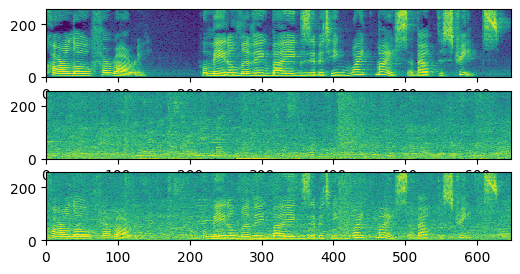

2025-03-02 14:03:49,889 __main__:59 <module> [INFO]: iter: 0, Lrec: 7.174e-01, L1(S): -4.844e-06, L(N): 8.332e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 


In [4]:
speech_file = random.choice(list(speech_folder.glob("*.wav")))
noise_file = random.choice(list(noise_folder.glob("*/*.wav")))
speech, sr = torchaudio.load(speech_file)
if sr != config.preprocess.sample_rate:
    speech = torchaudio.transforms.Resample(sr, config.preprocess.sample_rate)(speech)
noise, sr = torchaudio.load(noise_file)
if sr != config.preprocess.sample_rate:
    noise = torchaudio.transforms.Resample(sr, config.preprocess.sample_rate)(noise)
start_idx = random.randint(0, noise.size(1) - speech.size(1))
noise = noise[:, start_idx:start_idx + speech.size(1)]
logger.info(f"Speech file: {speech_file}")
logger.info(f"Noise file: {noise_file}")
noisy_speech = torchaudio.functional.add_noise(speech, noise, snr=torch.tensor([10]))
noise = noisy_speech - speech
display(Audio(speech.squeeze().numpy(), rate=config.preprocess.sample_rate))
display(Audio(noise.squeeze().numpy(), rate=config.preprocess.sample_rate))
display(Audio(noisy_speech.squeeze().numpy(), rate=config.preprocess.sample_rate))

Power_STFT = torchaudio.transforms.Spectrogram(
    n_fft=config.spec.fft_length,
    win_length=config.spec.fft_length,
    hop_length=config.spec.hop_length,
    power=2
)
speech_spec, noise_spec, noisy_speech_spec = Power_STFT(speech), Power_STFT(noise), Power_STFT(noisy_speech)
fig, axes = plt.subplots(3,1, figsize=(6, 3))
axes[0].pcolormesh(10 * torch.log10(speech_spec[0]), vmin=-80, vmax=20)
axes[1].pcolormesh(10 * torch.log10(noise_spec[0]), vmin=-80, vmax=20)
axes[2].pcolormesh(10 * torch.log10(noisy_speech_spec[0]), vmin=-80, vmax=20)
plt.show()

# Define
STFT = torchaudio.transforms.Spectrogram(
    n_fft=config.spec.fft_length,
    win_length=config.spec.fft_length,
    hop_length=config.spec.hop_length,
    power=None
).to(DEVICE)
ISTFT = torchaudio.transforms.InverseSpectrogram(
    n_fft=config.spec.fft_length,
    win_length=config.spec.fft_length,
    hop_length=config.spec.hop_length
).to(DEVICE)
noisy_spec = STFT(noisy_speech.to(DEVICE))
noisy_amp, noisy_angle = torch.abs(noisy_spec), torch.angle(noisy_spec)
noisy_amp = einops.rearrange(noisy_amp, "1 freq time -> 1 1 freq time")
model = SimpleTwinUnet(config.model).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=config.optimizer.lr)
loss = skddpLoss(config.loss, noisy_amp).to(DEVICE)
noisy_amp = einops.repeat(noisy_amp, "1 1 freq time -> batch 1 freq time", batch=config.optimizer.batch_size)
z1, z2 = model.get_input_features(noisy_amp)
log_step = config.optimizer.iter // config.logging_.log_freq
with torch.no_grad():
    clean_est, clean_est_merged, noise_est = model(z1, z2)
    loss_value, loss_logits = loss(clean_est, clean_est_merged, noise_est, noisy_amp)
    logger_output = "iter: 0, "
    for key, value in loss_logits.items():
        logger_output += f"{key}: {value:.3e}, "
    logger.info(logger_output)

2025-03-02 14:04:14,875 __main__:16 <module> [INFO]: saving intermediate step 10


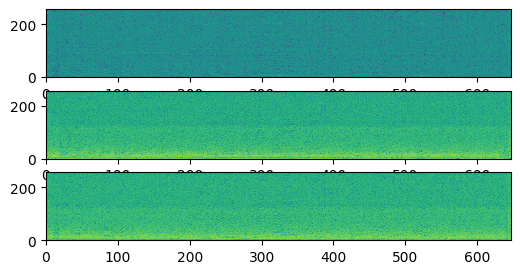

2025-03-02 14:04:16,356 __main__:13 <module> [INFO]: iter: 20, Lrec: 2.888e-01, L1(S): -5.154e-07, L(N): 7.479e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:18,913 __main__:13 <module> [INFO]: iter: 40, Lrec: 2.816e-01, L1(S): -5.039e-07, L(N): 7.327e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:21,470 __main__:13 <module> [INFO]: iter: 60, Lrec: 2.802e-01, L1(S): -9.140e-07, L(N): 7.336e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:24,026 __main__:13 <module> [INFO]: iter: 80, Lrec: 2.771e-01, L1(S): -3.253e-06, L(N): 7.334e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:26,584 __main__:13 <module> [INFO]: iter: 100, Lrec: 2.695e-01, L1(S): -5.041e-06, L(N): 7.274e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:26,584 __main__:16 <module> [INFO]: saving intermediate step 100


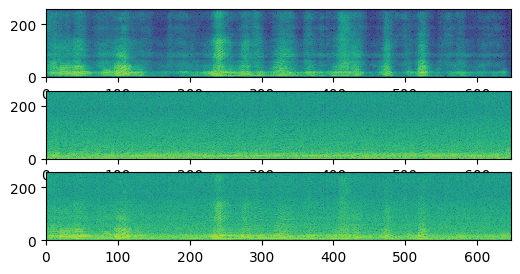

2025-03-02 14:04:29,326 __main__:13 <module> [INFO]: iter: 120, Lrec: 2.699e-01, L1(S): -6.593e-06, L(N): 7.301e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:31,884 __main__:13 <module> [INFO]: iter: 140, Lrec: 2.592e-01, L1(S): -9.688e-06, L(N): 7.371e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:34,444 __main__:13 <module> [INFO]: iter: 160, Lrec: 2.456e-01, L1(S): -1.354e-05, L(N): 7.309e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:37,004 __main__:13 <module> [INFO]: iter: 180, Lrec: 2.248e-01, L1(S): -1.566e-05, L(N): 7.359e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:39,564 __main__:13 <module> [INFO]: iter: 200, Lrec: 2.038e-01, L1(S): -2.035e-05, L(N): 7.536e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:04:42,125 __main__:13 <module> [INFO]: iter: 220, Lrec: 1.760e-01, L1(S): -2.752e-05, L(N): 7.485e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05,

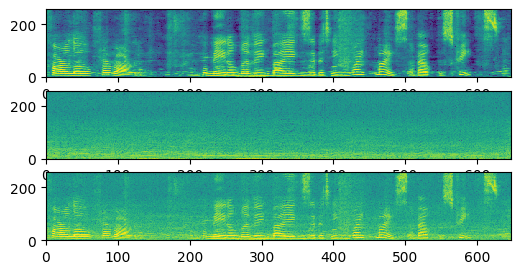

2025-03-02 14:05:20,759 __main__:13 <module> [INFO]: iter: 520, Lrec: 1.049e-01, L1(S): -4.930e-05, L(N): 8.990e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:05:23,320 __main__:13 <module> [INFO]: iter: 540, Lrec: 1.044e-01, L1(S): -5.009e-05, L(N): 8.923e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:05:25,883 __main__:13 <module> [INFO]: iter: 560, Lrec: 1.017e-01, L1(S): -5.151e-05, L(N): 9.219e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:05:28,446 __main__:13 <module> [INFO]: iter: 580, Lrec: 1.016e-01, L1(S): -5.116e-05, L(N): 9.251e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:05:31,009 __main__:13 <module> [INFO]: iter: 600, Lrec: 9.991e-02, L1(S): -5.179e-05, L(N): 9.146e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:05:33,573 __main__:13 <module> [INFO]: iter: 620, Lrec: 9.685e-02, L1(S): -5.332e-05, L(N): 9.632e-03, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05,

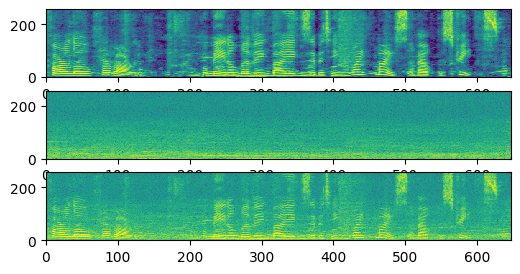

2025-03-02 14:06:24,999 __main__:13 <module> [INFO]: iter: 1020, Lrec: 7.796e-02, L1(S): -6.196e-05, L(N): 1.116e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:06:27,563 __main__:13 <module> [INFO]: iter: 1040, Lrec: 7.657e-02, L1(S): -6.214e-05, L(N): 1.144e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:06:30,125 __main__:13 <module> [INFO]: iter: 1060, Lrec: 7.447e-02, L1(S): -6.220e-05, L(N): 1.112e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:06:32,688 __main__:13 <module> [INFO]: iter: 1080, Lrec: 7.655e-02, L1(S): -6.249e-05, L(N): 1.113e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:06:35,251 __main__:13 <module> [INFO]: iter: 1100, Lrec: 7.406e-02, L1(S): -6.257e-05, L(N): 1.146e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.748e-05, 
2025-03-02 14:06:37,814 __main__:13 <module> [INFO]: iter: 1120, Lrec: 7.265e-02, L1(S): -6.275e-05, L(N): 1.154e-02, L2(S)_term1: 5.213e-05, L2(S)_term2: -2.74

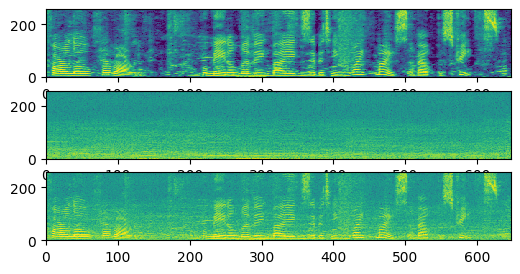

In [5]:
# Training iteration
for i in range(config.optimizer.iter):
    optimizer.zero_grad()
    clean_est, clean_est_mixed, noise_est = model(z1, z2)
    loss_value, loss_logits = loss(clean_est, clean_est_merged, noise_est, noisy_amp)
    loss_value.backward()
    optimizer.step()
    # logging
    if (i+1) % log_step == 0:
        logging_output = f"iter: {i+1}, "
        for key, value in loss_logits.items():
            logging_output += f"{key}: {value:.3e}, "
        logger.info(logging_output)
    # save
    if (i+1) in config.logging_.save_intermediate_steps:
        logger.info(f"saving intermediate step {i+1}")
        with torch.no_grad():
            # clean
            clean_est_mixed = einops.rearrange(clean_est_mixed, "1 1 freq time -> 1 freq time")
            clean_est_mixed = clean_est_mixed * torch.exp(1j*noisy_angle)
            clean_est_mixed = ISTFT(clean_est_mixed, length=noisy_speech.size(-1))
            clean_est_mixed = clean_est_mixed.detach().cpu()
            display(Audio(clean_est_mixed, rate=config.preprocess.sample_rate))
            # noise
            noise_est = einops.rearrange(noise_est, "1 1 freq time -> 1 freq time")
            noise_est = noise_est * torch.exp(1j*noisy_angle)
            noise_est = ISTFT(noise_est, length=noisy_speech.size(-1))
            noise_est = noise_est.detach().cpu()
            display(Audio(noise_est, rate=config.preprocess.sample_rate))
            # noisy
            noisy_est = clean_est_mixed + noise_est
            display(Audio(noisy_est, rate=config.preprocess.sample_rate))
            # plot
            clean_est_mixed_spec, noise_est_spec, noisy_est_spec = Power_STFT(clean_est_mixed), Power_STFT(noise_est), Power_STFT(noisy_est)
            fig, axes = plt.subplots(3,1, figsize=(6, 3))
            axes[0].pcolormesh(10 * torch.log10(clean_est_mixed_spec[0]), vmin=-80, vmax=20)
            axes[1].pcolormesh(10 * torch.log10(noise_est_spec[0]), vmin=-80, vmax=20)
            axes[2].pcolormesh(10 * torch.log10(noisy_est_spec[0]), vmin=-80, vmax=20)
            plt.show()
# save final
with torch.no_grad():
    logger.info(f"saving final step")
    clean_est_mixed = einops.rearrange(clean_est_mixed, "1 1 freq time -> 1 freq time")
    clean_est_mixed = clean_est_mixed * torch.exp(1j*noisy_angle)
    clean_est_mixed = ISTFT(clean_est_mixed, length=noisy_speech.size(-1))
    clean_est_mixed = clean_est_mixed.detach().cpu()
    display(Audio(clean_est_mixed, rate=config.preprocess.sample_rate))
    noise_est = einops.rearrange(noise_est, "1 1 freq time -> 1 freq time")
    noise_est = noise_est * torch.exp(1j*noisy_angle)
    noise_est = ISTFT(noise_est, length=noisy_speech.size(-1))
    noise_est = noise_est.detach().cpu()
    display(Audio(noise_est, rate=config.preprocess.sample_rate))
    noisy_est = clean_est_mixed + noise_est
    display(Audio(noisy_est, rate=config.preprocess.sample_rate))
    clean_est_mixed_spec, noise_est_spec, noisy_est_spec = Power_STFT(clean_est_mixed), Power_STFT(noise_est), Power_STFT(noisy_est)
    fig, axes = plt.subplots(3,1, figsize=(6, 3))
    axes[0].pcolormesh(10 * torch.log10(clean_est_mixed_spec[0]), vmin=-80, vmax=20)
    axes[1].pcolormesh(10 * torch.log10(noise_est_spec[0]), vmin=-80, vmax=20)
    axes[2].pcolormesh(10 * torch.log10(noisy_est_spec[0]), vmin=-80, vmax=20)
    plt.show()